In [217]:
import glob
import numpy as np
import pandas as pd
import cv2
import random 
import math
import os
import ipynb
import importlib
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
from skimage import transform
from torch.autograd import Variable

In [27]:
import ipynb.fs.full.BeeDataHandler as BeeDataHandler

In [28]:
importlib.reload(BeeDataHandler)

<module 'ipynb.fs.full.BeeDataHandler' (/Users/dieumynguyen/Documents/S2019_ObjectOrientedDesign/PyTorchPresentation/Bee Health CNNs/BeeDataHandler.ipynb)>

### Parameters

In [61]:
BATCH_SIZE = 4
BW = True
num_epochs = 100
learning_rate = 0.001

bee_dir = '/Users/dieumynguyen/Datasets/HoneyBees'

### Define transformations for data augmentation

In [55]:
transform_list = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.RandomRotation(degrees=180),
    transforms.RandomAffine(degrees=180, translate=(0, 0.2)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),  # Always need, div by 255 
    BeeDataHandler.CustomNormalize()
])

### Load data

In [56]:
# Wrapper around the data
# Could load data into np or a pointer/filepath
bee_data_src = BeeDataHandler.DataHandler(bee_dir, transforms=transform_list, bw=BW, test_split=0.2)

In [57]:
train_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.train_sampler)
test_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.test_sampler)

In [58]:
def sample_imgs():
    xxx = (X + 1) / 2.0
    grid_img = utils.make_grid(xxx)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(grid_img.permute(1,2,0))
    recovered_labels = [bee_data_src.idx_to_key[ele.item()] for ele in y]
    title_str = ""
    for recovered_label in recovered_labels:
        title_str += f"{recovered_label}                     "
    title_str = title_str[:-3]
    plt.title(title_str)

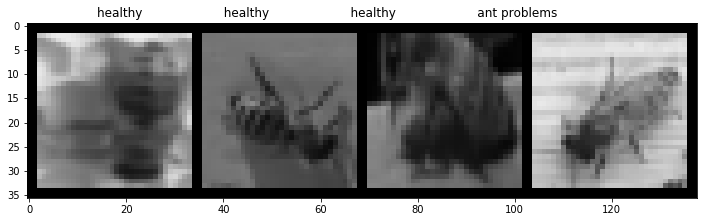

In [59]:
sample_imgs()

### CNN

$$ out = \frac{in - k + 2*P}{stride} + 1$$

$$ in = [(in - k + 2P) / S] + 1$$ 
$$ P = (S(in - 1) - in + k ) / 2$$ 
$$ P = (S*in - S - in + k ) / 2$$ 
$$ P = (in(S - 1) - S + k ) / 2$$ 

if S == 1:
$$ P = (k-S) / 2$$ 

In [136]:
def calculate_padding_for_SAME(in_size, k_size, stride=1):
    padding = (in_size * ( stride - 1) - stride + k_size) / 2 
    return int(padding)

In [137]:
def calculate_output_dimension(in_size, k_size, padding, stride=1):
    out_size = int(np.floor((in_size - k_size + 2*padding)/stride)) + 1
    return out_size

In [142]:
class CNN(nn.Module):
    
    def __init__(self, num_classes, num_in_channels, input_dim=100):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super(CNN, self).__init__()
        
        num_kernels = [5, 10, 50]
        k_sizes = [3, 3, 3]
        
        
        """ CONV LAYER 1 """
        """ ---------------------------------------- """
        padding_1 = calculate_padding_for_SAME(input_dim, k_size=k_sizes[0])     
        print("padding_1: ", padding_1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_kernels[0], kernel_size=k_sizes[0], padding=padding_1),
            nn.BatchNorm2d(num_kernels[0]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        output_dim_layer_1 = calculate_output_dimension(input_dim, k_sizes[0], padding=padding_1)
        output_dim_layer_1 = output_dim_layer_1 // 2
        print("output_dim_layer_1: ", output_dim_layer_1)
        """ ---------------------------------------- """
        
        
        
        """ CONV LAYER 2 """
        """ ---------------------------------------- """
        padding_2 = calculate_padding_for_SAME(output_dim_layer_1, k_size=k_sizes[1])
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_kernels[0], num_kernels[1], kernel_size=k_sizes[1], padding=padding_2),  
            nn.BatchNorm2d(num_kernels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        output_dim_layer_2 = calculate_output_dimension(output_dim_layer_1, k_sizes[1], padding=padding_2)
        output_dim_layer_2 = output_dim_layer_2 // 2
        print("output_dim_layer_2: ", output_dim_layer_2)
        """ ---------------------------------------- """
        
        
        
        
        """ CONV LAYER 3 """
        """ ---------------------------------------- """
        padding_3 = calculate_padding_for_SAME(output_dim_layer_2, k_size=k_sizes[2])        
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_kernels[1], num_kernels[2], kernel_size=k_sizes[2], padding=padding_3),  
            nn.BatchNorm2d(num_kernels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        output_dim_layer_3 = calculate_output_dimension(output_dim_layer_2, k_sizes[2], padding=padding_3)
        output_dim_layer_3 = output_dim_layer_3 // 2
        print("output_dim_layer_3: ", output_dim_layer_3)
        """ ---------------------------------------- """
        
        
        """ FULLY CONNECTED """
        """ ---------------------------------------- """
        flat_shape = num_kernels[2] * output_dim_layer_3 * output_dim_layer_3 
        
        self.fc = nn.Sequential(
            nn.Linear(flat_shape, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(100, num_classes)
        )
        """ ---------------------------------------- """
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Flatten
        out = out.view(out.size(0), -1) 
        
        # Fully Connected
        out = self.fc(out)
        out = F.softmax(out, dim=0)
        
        return out
        

In [143]:
# Instantiate an instance of the conv net
num_classes = bee_data_src.num_classes
num_in_channels = 1 if BW else 3
cnn = CNN(num_classes=num_classes, num_in_channels=num_in_channels)

# Loss function and optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

padding_1:  1
output_dim_layer_1:  50
output_dim_layer_2:  25
output_dim_layer_3:  12


### Train

In [183]:
losses = []
test_accuracies = []

try:
    for epoch_i in range(num_epochs):
        cnn.train()
        batch_losses = []
        for batch_i, (images, labels) in enumerate(train_dataloader):

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add loss values to array to print out progress of training
            batch_losses.append(loss.data) 

            if (batch_i+1) % 100 == 0:
                num_batches = len(train_dataloader)
                print(f'Epoch: {epoch_i+1}/{num_epochs}, Batch: {batch_i+1}/{num_batches}, Loss: {loss.data:.6f}')

        if epoch_i % 1 == 0:
            test_acc = evaluate_cnn()
            test_accuracies.append((epoch_i, test_acc))
            
        losses.append(np.mean(batch_losses))
except KeyboardInterrupt:
    print("\nEnding Early.")

Epoch: 1/100, Batch: 100/1035, Loss: 1.598523
Epoch: 1/100, Batch: 200/1035, Loss: 1.844299
Epoch: 1/100, Batch: 300/1035, Loss: 1.260532
Epoch: 1/100, Batch: 400/1035, Loss: 1.838621
Epoch: 1/100, Batch: 500/1035, Loss: 1.616327
Epoch: 1/100, Batch: 600/1035, Loss: 1.833809
Epoch: 1/100, Batch: 700/1035, Loss: 1.625839
Epoch: 1/100, Batch: 800/1035, Loss: 1.630243
Epoch: 1/100, Batch: 900/1035, Loss: 1.860430
Epoch: 1/100, Batch: 1000/1035, Loss: 1.854648
Test accuracy: 36%
Epoch: 2/100, Batch: 100/1035, Loss: 1.712543
Epoch: 2/100, Batch: 200/1035, Loss: 1.383202
Epoch: 2/100, Batch: 300/1035, Loss: 1.777331
Epoch: 2/100, Batch: 400/1035, Loss: 1.760819
Epoch: 2/100, Batch: 500/1035, Loss: 1.621491
Epoch: 2/100, Batch: 600/1035, Loss: 1.806363
Epoch: 2/100, Batch: 700/1035, Loss: 2.041094
Epoch: 2/100, Batch: 800/1035, Loss: 1.672061
Epoch: 2/100, Batch: 900/1035, Loss: 1.491941
Epoch: 2/100, Batch: 1000/1035, Loss: 1.587839
Test accuracy: 37%
Epoch: 3/100, Batch: 100/1035, Loss: 1.8

Test accuracy: 41%
Epoch: 18/100, Batch: 100/1035, Loss: 1.805541
Epoch: 18/100, Batch: 200/1035, Loss: 1.896751
Epoch: 18/100, Batch: 300/1035, Loss: 1.611619
Epoch: 18/100, Batch: 400/1035, Loss: 1.549169
Epoch: 18/100, Batch: 500/1035, Loss: 1.612209
Epoch: 18/100, Batch: 600/1035, Loss: 1.686531
Epoch: 18/100, Batch: 700/1035, Loss: 1.705513
Epoch: 18/100, Batch: 800/1035, Loss: 1.850407
Epoch: 18/100, Batch: 900/1035, Loss: 1.582327
Epoch: 18/100, Batch: 1000/1035, Loss: 1.340343
Test accuracy: 43%
Epoch: 19/100, Batch: 100/1035, Loss: 1.758229
Epoch: 19/100, Batch: 200/1035, Loss: 1.362287
Epoch: 19/100, Batch: 300/1035, Loss: 1.586481
Epoch: 19/100, Batch: 400/1035, Loss: 1.828114
Epoch: 19/100, Batch: 500/1035, Loss: 1.419087
Epoch: 19/100, Batch: 600/1035, Loss: 1.771473
Epoch: 19/100, Batch: 700/1035, Loss: 1.359043
Epoch: 19/100, Batch: 800/1035, Loss: 1.700709
Epoch: 19/100, Batch: 900/1035, Loss: 1.649176
Epoch: 19/100, Batch: 1000/1035, Loss: 1.605592
Test accuracy: 43%
E

Epoch: 34/100, Batch: 900/1035, Loss: 1.571317
Epoch: 34/100, Batch: 1000/1035, Loss: 1.567446
Test accuracy: 49%
Epoch: 35/100, Batch: 100/1035, Loss: 1.823861
Epoch: 35/100, Batch: 200/1035, Loss: 1.577128
Epoch: 35/100, Batch: 300/1035, Loss: 1.594523
Epoch: 35/100, Batch: 400/1035, Loss: 1.824629
Epoch: 35/100, Batch: 500/1035, Loss: 1.609308
Epoch: 35/100, Batch: 600/1035, Loss: 1.824676
Epoch: 35/100, Batch: 700/1035, Loss: 1.599805
Epoch: 35/100, Batch: 800/1035, Loss: 1.565974
Epoch: 35/100, Batch: 900/1035, Loss: 1.575119
Epoch: 35/100, Batch: 1000/1035, Loss: 1.516113
Test accuracy: 46%
Epoch: 36/100, Batch: 100/1035, Loss: 1.604047
Epoch: 36/100, Batch: 200/1035, Loss: 1.809898
Epoch: 36/100, Batch: 300/1035, Loss: 1.878870
Epoch: 36/100, Batch: 400/1035, Loss: 1.813692
Epoch: 36/100, Batch: 500/1035, Loss: 1.832779
Epoch: 36/100, Batch: 600/1035, Loss: 1.572382
Epoch: 36/100, Batch: 700/1035, Loss: 1.424138
Epoch: 36/100, Batch: 800/1035, Loss: 1.826053
Epoch: 36/100, Batch

In [168]:
cnn.layer2[0].weight.shape

torch.Size([10, 5, 3, 3])

In [169]:
import torchvision.utils

In [176]:
W = cnn.layer1[0].weight
W.shape

torch.Size([5, 1, 3, 3])

In [177]:
W = (W - W.min()) / (W.max() - W.min())
W.shape

torch.Size([5, 1, 3, 3])

In [178]:
grid_img = utils.make_grid(W)
grid_img.shape

torch.Size([3, 7, 27])

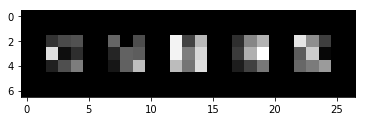

In [179]:
plt.imshow(grid_img.permute(1,2,0).detach())

In [180]:
def evaluate_cnn():
    cnn.eval()
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100*correct/total
    print(f"Test accuracy: {accuracy}%")
    return accuracy

In [220]:
cnn.eval()
confusion_matrix = torch.zeros((num_classes, num_classes))
for X, y in train_dataloader:
    outputs = cnn(X)
    y_preds = outputs.max(dim=1)[1]
    for y_true, y_pred in zip(y, y_preds):
        confusion_matrix[y_true, y_pred] += 1
    
    
outputs.shape



torch.Size([2, 6])

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

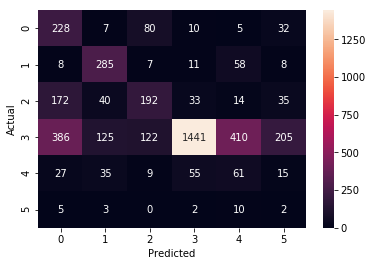

In [225]:
ax = sns.heatmap(confusion_matrix.int(), annot=True, fmt="d")
ax.set(xlabel="Predicted", ylabel="Actual")

In [227]:
bee_data_src.idx_to_key[3]

'healthy'